# Face detection and recognition inference pipeline

The following example illustrates how to use the `facenet_pytorch` python package to perform face detection and recogition on an image dataset using an Inception Resnet V1 pretrained on the VGGFace2 dataset.

The following Pytorch methods are included:
* Datasets
* Dataloaders
* GPU/CPU processing

In [35]:
from facenet_pytorch import MTCNN, InceptionResnetV1, training
import torch
from torch.utils.data import DataLoader
from torchvision import datasets
import numpy as np
import pandas as pd
import os

workers = 0 if os.name == 'nt' else 4
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Running on device: {}'.format(device))

Running on device: cuda:0


In [36]:
mtcnn = MTCNN(
    image_size=160, margin=0, min_face_size=20,
    thresholds=[0.6, 0.7, 0.7], factor=0.709, post_process=True,
    device=device
)
resnet = InceptionResnetV1(pretrained='casia-webface').eval().to(device)

In [37]:
def collate_fn(x):
    return x[0]

dataset = datasets.ImageFolder('../hard_images')
dataset.idx_to_class = {i:c for c, i in dataset.class_to_idx.items()}
loader = DataLoader(dataset, collate_fn=collate_fn, num_workers=workers)
dataset.idx_to_class

{0: 'Ariana_Grande',
 1: 'Ayumi_Hamasaki',
 2: 'Haruka_Imai',
 3: 'Haruna_Kawaguchi',
 4: 'Yui_Aragaki'}

In [34]:

# only get one image per person
# people = set()
def crop_faces(loader, dataset):
    aligned = []
    names = []
    for x, y in loader:
        person = dataset.idx_to_class[y]
        # if person in people:
        #     continue
        # people.add(person)
        x_aligned, prob = mtcnn(x, return_prob=True)
        if x_aligned is not None:
            #print('Face detected with probability: {:8f}'.format(prob))
            aligned.append(x_aligned)
            names.append(person)
        else:
            # print path of images that are not detected
            print(f"person not detection {person}")
    return aligned, names

def create_embeddings(loader, dataset):
    aligned, names = crop_faces(loader, dataset)
    # split up aligned images into batches
    aligned = torch.stack(aligned)
    aligned = torch.split(aligned, 32)
    # pass each batch through resnet
    embeddings = []
    for batch in aligned:
        embeddings.extend(resnet(batch.to(device)).detach().cpu())
    # convert embeddings to numpy
    embeddings= torch.stack(embeddings).numpy()
    names = np.array(names)
    return embeddings, names, aligned

#embeddings, names, aligned = create_embeddings(loader, dataset)

In [105]:

# save embeddings and names
# np.save('embeddings_hard.npy', embeddings)
# np.save('names_hard.npy', names)
np.save('embeddings_all.npy', embeddings)
np.save('names_all.npy', names)

In [64]:
import numpy as np
# load in embeddings
embeddings = np.load('embeddings_hard.npy')
names = np.load('names_hard.npy')

In [65]:
generated_images_data = "../generated_images"
generated_images_dataset = datasets.ImageFolder(generated_images_data)
generated_images_dataset.idx_to_class = {i:c for c, i in generated_images_dataset.class_to_idx.items()}
generated_images_loader = DataLoader(generated_images_dataset, collate_fn=collate_fn, num_workers=workers)

# create embeddings
embeddings_gen, names_gen, aligned_gen = create_embeddings(loader=generated_images_loader, dataset=generated_images_dataset)


#### Calculate image embeddings

MTCNN will return images of faces all the same size, enabling easy batch processing with the Resnet recognition module. Here, since we only have a few images, we build a single batch and perform inference on it. 

For real datasets, code should be modified to control batch sizes being passed to the Resnet, particularly if being processed on a GPU. For repeated testing, it is best to separate face detection (using MTCNN) from embedding or classification (using InceptionResnetV1), as calculation of cropped faces or bounding boxes can then be performed a single time and detected faces saved for future use.

In [31]:
# autoreload for development
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [66]:

import numpy as np
import faiss
from sklearn.metrics import roc_curve, auc
from verifier import FacialVerifier

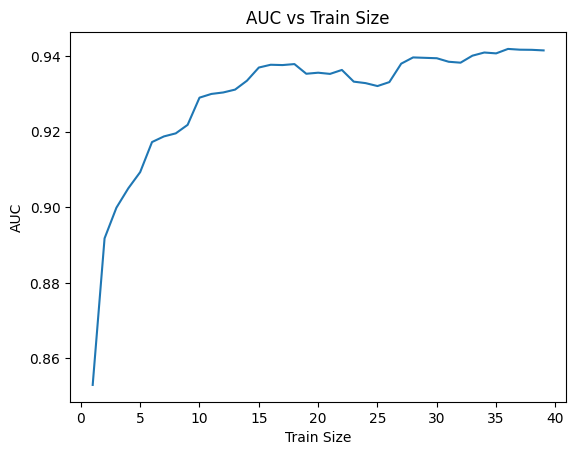

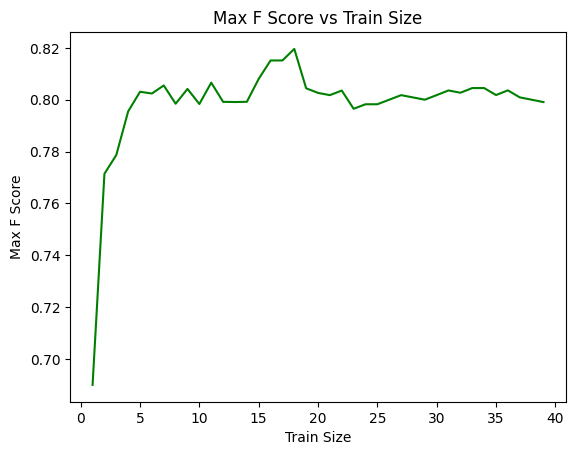

In [70]:

from matplotlib import pyplot as plt
def get_auc_for_train_size(embeddings, names, celeb_name, train_size):
    celeb_embedding = embeddings[names == celeb_name]
    known_embeddings = celeb_embedding[:train_size]
    known_indices = np.where(np.isin(names, celeb_name))[0][:train_size]
    # Create a boolean mask for the remaining indices
    mask = np.ones(len(embeddings), dtype=bool)
    mask[known_indices] = False
    # Use the mask to filter test_embeddings and test_names
    test_embeddings = embeddings[mask]
    test_names = names[mask]
    
    verifier = FacialVerifier(known_embeddings=known_embeddings)
    thresholds = np.arange(0, 2, 0.05)
    fpr_list, tpr_list, accuracies, f_scores, _ = verifier.test_thresholds(test_embeddings, true_labels=test_names, name=celeb_name, thresholds=thresholds)

    # remove nan values from f_scores
    f_scores = [f for f in f_scores if not np.isnan(f)]
    max_f_score = max(f_scores)
    max_accuracy = max(accuracies)
    auc = verifier.compute_auc(fpr_list, tpr_list)
    return auc, max_accuracy, max_f_score

def get_auc_for_gen_embeddings(generated_embeddings, embeddings, names, celeb_name, train_size=None):
    if train_size == None:
        train_size = len(generated_embeddings)
    known_embeddings = generated_embeddings[:train_size]
    verifier = FacialVerifier(known_embeddings=known_embeddings)
    thresholds = np.arange(0, 2, 0.05)
    fpr_list, tpr_list, accuracies, f_scores, _ = verifier.test_thresholds(embeddings, true_labels=names, name=celeb_name, thresholds=thresholds)
    max_accuracy = max(accuracies)
    # remove nan values from f_scores
    f_scores = [f for f in f_scores if not np.isnan(f)]
    max_f_score = max(f_scores)
    auc = verifier.compute_auc(fpr_list, tpr_list)
    return auc, max_accuracy, max_f_score

def plot_auc_train_size(embeddings, names, celeb_name):
    aucs = []
    max_accuracies = []
    max_f_scores = []
    train_sizes = list(range(1, 40, 1))
    for train_size in train_sizes:
        auc, max_accuracy, max_f_score = get_auc_for_train_size(embeddings, names, celeb_name, train_size)
        aucs.append(auc)
        max_accuracies.append(max_accuracy)
        max_f_scores.append(max_f_score)
    plt.plot(train_sizes, aucs)
    plt.xlabel('Train Size')
    plt.ylabel('AUC')
    plt.title('AUC vs Train Size')
    plt.show()
    # plot max accuracies color line green
    plt.plot(train_sizes, max_f_scores, color='green')
    plt.xlabel('Train Size')
    plt.ylabel('Max F Score')
    plt.title('Max F Score vs Train Size')
    # color line green
    plt.show()
    return aucs, max_f_scores, train_sizes

# test_names = np.array(['n009117', 'n003357'])
# mask = np.isin(names, test_names)
# test_embeddings = embeddings[mask]
# test_names = names[mask]
aucs, max_f_scores, train_sizes = plot_auc_train_size(embeddings, names, 'n003357') # n000854 n003357 n009117 

[0, 1, 2, 3, 4, 5]


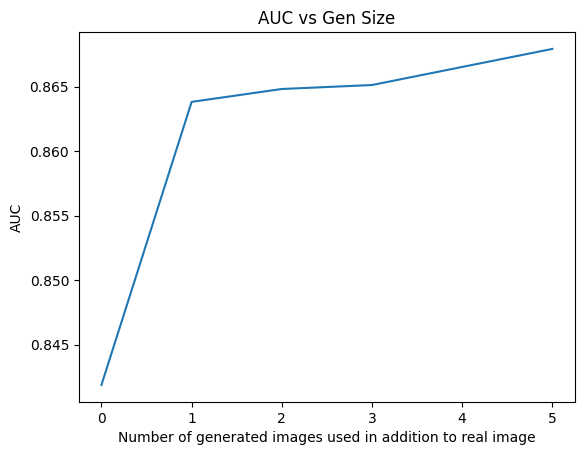

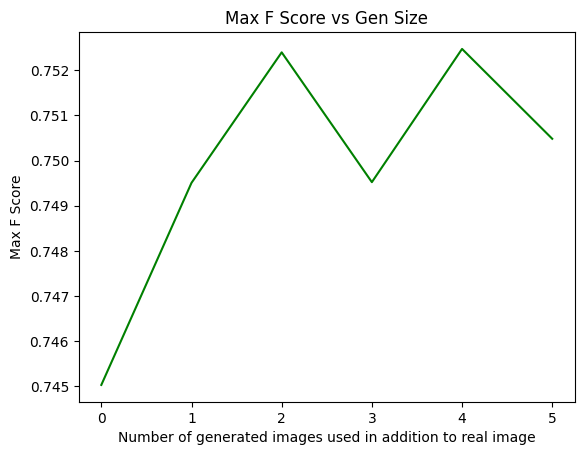

In [69]:

# test generated accuracy using real embeddings and certain number of generated embeddings as known embeddings plot auc over gen size
def test_generated_accuracy(gen_embeddings, real_embeddings, embeddings, names, celeb_name):
    aucs = []
    max_accuracies = []
    max_f_scores = []
    gen_sizes = list(range(0, len(gen_embeddings)+1, 1))
    print(gen_sizes)
    for gen_size in gen_sizes:
        known_embeddings = np.concatenate((gen_embeddings[:gen_size], real_embeddings[2:]))
        auc, max_accuracy, max_f_score = get_auc_for_gen_embeddings(known_embeddings, embeddings, names, celeb_name)
        aucs.append(auc)
        max_accuracies.append(max_accuracy)
        max_f_scores.append(max_f_score)
    plt.plot(gen_sizes, aucs)
    plt.xlabel('Number of generated images used in addition to real image')
    plt.ylabel('AUC')
    plt.title('AUC vs Gen Size')
    plt.show()
    # plot max f_scores color line green
    plt.plot(gen_sizes, max_f_scores, color='green')
    plt.xlabel('Number of generated images used in addition to real image')
    plt.ylabel('Max F Score')
    plt.title('Max F Score vs Gen Size')

    # color line green
    plt.show()
    return aucs, max_accuracies, gen_sizes

gen_embeddings = embeddings_gen[(names_gen == 'high_res_hk3_swapped_1024')][:5]
real_embeddings = embeddings_gen[(names_gen == 'high_res_source')]
aucs, max_accuracies, gen_sizes = test_generated_accuracy(gen_embeddings, real_embeddings, embeddings, names, 'n003357')
# swapped_embeddings = embeddings_gen[(names_gen == '0008_source')]#[0].reshape(-1, 512)
# swapped_embeddings.shape
# auc, max_accuracy, max_f_score = get_auc_for_gen_embeddings(generated_embeddings=swapped_embeddings, embeddings=embeddings, names=names, celeb_name="n003357")
# print(f"MAX AUC IS {auc}, max_accuray {max_accuracy}, max_fscore {max_f_score}")
# print("TESTING ON BASE IMAGES NOW")
# auc, max_accuracy = get_auc_for_train_size(embeddings, names, celeb_name="n003357", train_size=1)
# print(f"BASE AUC IS {auc}")

In [58]:
import pickle
from verifier import FacialVerifier
def create_and_save_Verifier(embeddings, celeb_name, file_path, train_size=1):
    celeb_embedding = embeddings[names == celeb_name]
    known_embeddings = celeb_embedding[:train_size]
    verifier = FacialVerifier(known_embeddings=known_embeddings)
    thresholds = np.arange(0, 2, 0.05)
    verifier.test_thresholds(embeddings, true_labels=names, name=celeb_name, thresholds=thresholds)
    with open(file_path, 'wb') as f:
        pickle.dump(verifier, f)
create_and_save_Verifier(embeddings, 'n003357', 'verifier_Haruna_Kawaguchi.pkl', train_size=10)

d:\projects\Gen-AI\FaceAugment\examples\verifier.py:74: RuntimeWarning: invalid value encountered in scalar divide
  precision = tp / (tp + fp)
